<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/%EC%8B%AC%ED%99%941_%EC%96%B4%ED%85%90%EC%85%98%EC%9D%98_%EC%89%BD%EA%B3%A0_%EA%B7%BC%EB%B3%B8%EC%A0%81%EC%9D%B8_%EC%9D%B4%ED%95%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 시간에는 **어텐션(Attention)의 근본적인 이해**를 해보도록 하겠습니다.  
어텐션은 단어(**It**)와 문장(**The** **animal** **didn't** **cross** **the** **street** **because** **it was too tired**) 내의 단어 각각과의  
닮은 정도를 나타내는 것입니다.  
![Imgur](https://i.imgur.com/x1GYPP0.png)  
  출처 : http://jalammar.github.io/illustrated-transformer/
  
  그림을 보면서 감을 잡아보도록 하겠습니다.  
**The animal didn't cross the street because it was too tired (그 동물은 길을 건너지 않았다. 왜냐하면 It(그 동물)은 너무 지쳤기 때문이다.)**  
그림에서는 실선의 진한 정도로 It과 앞 문장안의 단어들간의 관계를 표현하고 있습니다.  
**It(동물)**은 사실 **앞 문장**에서 **The animal**이기 때문에, **The animal**과의 관계가 가장 진한 실선으로 크게 나타납니다. 그렇다고 해서 다른 단어들간의 관계 또한 아예 없는 것도 아닙니다. 문장 속에서 단어를, 다른 문장 내부의 단어들과의 관계의 정도를 나타내는 방식을 어텐션이라고 합니다.


같은 문장과 같은 문장의 어텐션을 **Self Attention**이라고 합니다.  
**트랜스포머나, 버트 모형**에서는 셀프 어텐션을 사용해서 **단어와 문장간의 관계**를 즉, **닮은 정도**를 딥-러닝을 통해 학습하게 됩니다.


버트나 트랜스포머를 직접 구현하면서 배우는 어텐션은 처음에 구현하기에 난도가 높은 편이므로, 간단하게 word2vec을 약간 개선한 glove를 활용하여 직접 어텐션을 구현해보고, 그림으로 나타내보도록 하겠습니다.

분석에 필요한 모듈을 임포트합니다.

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import gensim
import os, requests, shutil

import re

영어 단어 하나 하나를 임베딩 한 glove를 로드합니다.

In [41]:
glove_dir = './glove'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'


download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    

    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:

        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    

print("GloVE available locally")

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

word_embedding = loadGloveModel(glove_100k_50d_path)

GloVE available locally
Loading Glove Model
Done. 100000  words loaded!


임베딩 벡터들이 잘 로드되었는지 10단어만 확인해보도록 하겠습니다.

In [42]:
[(x,y) for x,y in word_embedding.items()][:10]

[('the',
  array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
         -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
          2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
          1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
         -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
         -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
          4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
          7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
         -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
          1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])),
 (',', array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
         -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
         -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
         -0.41634 

sen2vec 함수를 정의합니다.  
문장을 단어들의 임베딩 벡터로 변환해줍니다.  
i have a boyfriend 라는 문장을 예로 들면,  
[i, have, a, boyfriend]로 split 되고,  
i에 해당하는 임베딩 벡터(50차원), have에 해당하는 임베딩 벡터(50차원), a에 해당하는 임베딩 벡터(50차원), boyfriend에 해당하는 임베딩 벡터(50차원)의 묶음이 리턴됩니다.  
즉 [i(임베딩벡터), have(임베딩벡터), a(임베딩벡터), boyfriend(임베딩벡터)]를 리턴하게 됩니다.

In [0]:
def sen2vec(sentence):
  sentence = sentence.lower()
  sent_list = list(map(lambda x: re.sub(r'[^a-zA-Z]+', "", x), sentence.split()))
  
  vecs = []
  for word in sent_list:
    try:
      word_vec = word_embedding[word]
      vecs.append(word_vec)
    except:
      word_vec = np.zeros(50)
      vecs.append(word_vec)
  return np.array(vecs)

In [44]:
sen_vec = sen2vec("i have a boyfriend")
print(sen_vec)

[[ 1.1891e-01  1.5255e-01 -8.2073e-02 -7.4144e-01  7.5917e-01 -4.8328e-01
  -3.1009e-01  5.1476e-01 -9.8708e-01  6.1757e-04 -1.5043e-01  8.3770e-01
  -1.0797e+00 -5.1460e-01  1.3188e+00  6.2007e-01  1.3779e-01  4.7108e-01
  -7.2874e-02 -7.2675e-01 -7.4116e-01  7.5263e-01  8.8180e-01  2.9561e-01
   1.3548e+00 -2.5701e+00 -1.3523e+00  4.5880e-01  1.0068e+00 -1.1856e+00
   3.4737e+00  7.7898e-01 -7.2929e-01  2.5102e-01 -2.6156e-01 -3.4684e-01
   5.5841e-01  7.5098e-01  4.9830e-01 -2.6823e-01 -2.7443e-03 -1.8298e-02
  -2.8096e-01  5.5318e-01  3.7706e-02  1.8555e-01 -1.5025e-01 -5.7512e-01
  -2.6671e-01  9.2121e-01]
 [ 9.4911e-01 -3.4968e-01  4.8125e-01 -1.9306e-01 -8.8384e-03  2.8182e-01
  -9.6130e-01 -1.3581e-01 -4.3083e-01 -9.2933e-02  1.5689e-01  5.9585e-02
  -4.9635e-01 -1.7414e-01  7.5661e-01  4.9210e-01  2.1773e-01 -2.2778e-01
  -1.3686e-01 -9.0589e-01 -4.8781e-01  1.9919e-01  9.1447e-01 -1.6203e-01
  -2.0645e-01 -1.7312e+00 -4.7622e-01 -4.8540e-02 -1.4027e-01 -4.5828e-01
   4.0326e+

In [45]:
# 4개의 단어, 단어 하나하나당 50차원의 벡터
sen_vec.shape

(4, 50)

Softmax 함수를 정의해줍니다.  
왜 Softmax를 사용하냐면, 단어와 문장을 inner product(내적)한 후,  
softmax 함수를 통해서 내적의 값을 0과 1 사이로 스케일링 해 줍니다.  

  
a 벡터와 b 벡터를 내적한다는 것의 의미는, a와 b가 얼마나 가까운지를 나타내는 것입니다.  
자연어에서는 단어 a의 임베딩과 단어 b의 임베딩을 내적하는 것입니다.  
만약 벡터 a가 [x1,x2], 벡터 b가 [y1,y2]라면 내적 값은 x1 * y1 + x2 * y2 입니다.   
그리고 a와 b의 내적은 lallblcos(θ) = x1 * y1 + x2 * y2 이기 때문에 a와 b가 가까울 수록, 내적의 값은 일반적으로 커지게 됩니다. 

![Imgur](https://i.imgur.com/8CWYkqO.jpg)


softmax 함수에서, 가로 축의 합이 1이 되게 만들어 줍니다.  
만약 (단어1, 단어2)를 (단어3, 단어4)와 내적하고 소프트맥스 함수를 출력하면, 2 x 2 행렬이 나오게 됩니다.  

예를 들어 단어 1, 단어 2를 [1,0] 이라 가정하고, 단어 3, 단어 4를 [4,9]라 가정한다면,   
아웃풋 값은 [[0.73, 0.27], [0.006, 0.993]]  이 되는데,   
첫 번째 행인 [0.73, 0.27]의 의미는 단어 1을 단어 3, 단어 4와 내적하고 소프트맥스 계층을 출력했을 때의 값입니다.  
두 번째 행인 [0.006, 0.993]의 의미는 마찬가지로 단어 2를 단어 3, 단어 4와 내적한 다음 소프트맥스 계층을 출력했을 때의 값을 의미합니다.  
  

엄밀하진 않지만, 쉽게 설명 드리자면 **단어 1은 단어 3과 0.73만큼** 닮았고, **단어 4와 0.27만큼** 닮았다는 뜻입니다.  
**단어 2는 단어 3과 0.006만큼** 닮았고, **단어 4와 0.993만큼** 닮았다는 뜻입니다.  
  
약간 헷갈리실 수 있는데, 단어는 50차원을 가진다고 했었는데 너무 단순하게 가정했습니다.  
그렇지만 사실 50차원이라 가정해도 결과는 동일합니다 왜냐하면 단어 1과 단어 2는 (2, 50) 차원이고, 단어 3과 4 또한 (2,50) 차원이고, 단어 1과 단어 2의 묶음을 행렬 A라 가정하고, 단어 3과 4를 B라 가정하면, 내적 값은 행렬곱 A * (B의 전치행렬) 이 되어서 2 * 2 행렬을 최종 출력값으로 나타냅니다.

In [46]:
def softmax(x):
    e_x = x - np.max(x, axis=-1)[np.newaxis,:].T
    e_x = np.exp(e_x)
    return e_x / e_x.sum(axis = - 1)[np.newaxis,:].T

scores = np.array([[1,0],[4,9]])
print(softmax(scores))

[[0.73105858 0.26894142]
 [0.00669285 0.99330715]]


In [61]:
0.7*4+0.3*9, 0.006*4+0.993*9

(5.5, 8.960999999999999)

예를 들어 **문장1 : (단어1, 단어2)** **문장2 : (단어3, 단어4)** 라 했을 때,  
소프트맥스 함수 결과가 (0.7, 0.3), (0.006, 0.994)가 나왔다고 치겠습니다.  
이 결과가 의미하는 것은 **단어 1 은 단어 3과 0.7의 관계**, **단어 4와 0.3의 관계**가 있다는 의미입니다.  
마찬가지로 **단어 2는 단어 3과 0.006의 관계**, **단어 4와 0.99의 관계**가 있다는 의미입니다.

어텐션을 계산하는 일반적인 함수를 만들어보도록 하겠습니다.  
attention_weights는 문장1과 문장2의 소프트맥스 함수 값,  
output은 문장 1의 단어를 문장 2의 조합으로 나타낸 결과를 나타냅니다.  
output의 값은  단어 1 = 0.7 * 단어3 + 0.3 * 단어 4  
단어 2 = 0.006 * 단어 3 + 0.3 * 단어 4 과 같은 방식으로 표현한 것입니다.

In [0]:
def get_attention_output(query, key, value):
  qk = np.matmul(query, key.T) # query와 key의 내적, query shape = (문장길이, 50차원), key shape = (문장길이, 50차원), value shape = (문장길이, 50차원)
                               # dk 차원은 = (문장길이 * 문장길이)
                               # 참고로 문장길이는 문장 내의 단어의 수( I have a boyfriend에서 단어의 수는 4)

  d = key.shape[-1]
  
  logit = qk / np.sqrt(d) # 단어의 루트(길이)로 나눠줌

  attention_weights = softmax(logit) # 소프트맥스 함수 적용
  output = np.matmul(attention_weights, value) # 소프트 맥스 함수에 value를 곱하면 문장 1을 문장2의 단어로 표현하면 무슨 관계인지 나타내주는 값 출력

  return attention_weights, output

query, key, value를 다 같은 함수로 입력하면 self-attention임(자기 자신과의 내적값 계산)  
트랜스포머의 인코더나 버트에서는 query, key, value가 같은 문장이 들어감

In [50]:
get_attention_output(sen_vec, sen_vec, sen_vec)

(array([[0.82539694, 0.09316572, 0.06088821, 0.02054913],
        [0.24189774, 0.62320525, 0.11484694, 0.02005007],
        [0.20616176, 0.14976789, 0.59562366, 0.04844669],
        [0.17029765, 0.06399637, 0.11857808, 0.6471279 ]]),
 array([[ 0.20148931,  0.1350191 , -0.04919069, -0.62667824,  0.69878051,
         -0.30134875, -0.39557182,  0.41363015, -0.85503068,  0.00940032,
         -0.12359533,  0.68384829, -0.96897992, -0.40569282,  1.19472097,
          0.53073572,  0.12215698,  0.37948309, -0.11376776, -0.69177315,
         -0.66608226,  0.68251418,  0.76935583,  0.24410869,  1.09479813,
         -2.4502045 , -1.16545866,  0.40233508,  0.84878785, -1.01198183,
          3.49924182,  0.65185857, -0.6336274 ,  0.15874573, -0.16779519,
         -0.27276485,  0.4646489 ,  0.63311789,  0.42229858, -0.25748515,
         -0.0596501 ,  0.05494532, -0.23567894,  0.54065008,  0.07713821,
          0.11268194, -0.2033952 , -0.47057798, -0.25308031,  0.72569551],
        [ 0.64684167, -0.

In [0]:
def plot_attention_weights(sentence1, sentence2):
  fig = plt.figure(figsize=(8, 8))
  sen_len1 = len(sentence1.split())
  sen_len2 = len(sentence2.split())
  sent_embedding1 = sen2vec(sentence1)
  sent_embedding2 = sen2vec(sentence2)
  attention, _ = get_attention_output(sent_embedding1, sent_embedding2, sent_embedding2)
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='gray')

  fontdict = {'fontsize': 10}
  ax.set_xticks(range(sen_len2))
  ax.set_yticks(range(sen_len1))    
        
  ax.set_xticklabels([i for i in sentence2.split()], fontdict=fontdict)
  ax.set_yticklabels([i for i in sentence1.split()], fontdict=fontdict)
  
  for (i, j), z in np.ndenumerate(attention):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', c='r')

  plt.tight_layout()
  plt.show()

그림으로 보면서 알아보도록 하겠습니다.  
**같은 문장끼리의 어텐션 값 출력 -> 셀프 어텐션**

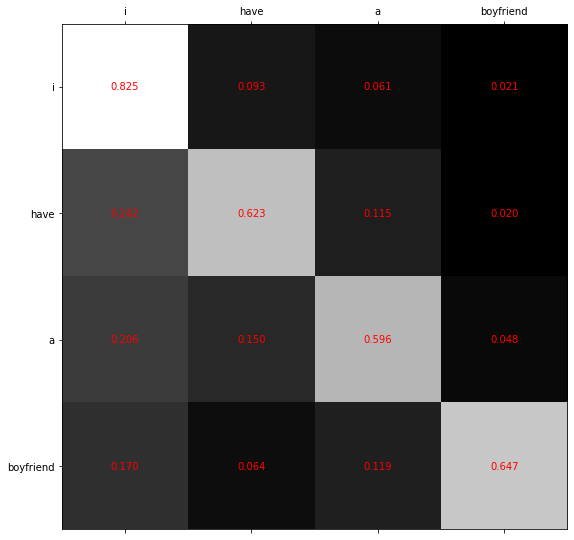

In [52]:
plot_attention_weights("i have a boyfriend", "i have a boyfriend")

In [62]:
#boyfriend에 해당하는 어텐션 값
0.170*sen2vec("i") + 0.064*sen2vec("have") + 0.119*sen2vec("a") + 0.647*sen2vec("boyfriend")

array([[ 0.16034535,  0.47957976,  0.03002168, -0.21607726,  0.60416687,
         0.83479433, -0.7356768 ,  0.59505765, -0.50268774,  0.30966365,
        -0.00994146,  0.52705465, -0.81798531,  0.095091  ,  1.15476106,
         0.06518995, -0.27988708,  0.06770148,  0.0971266 , -0.055953  ,
        -0.2617946 ,  1.19704568, -0.05487257,  0.85145882,  0.30843437,
        -1.7731391 , -0.01351534,  0.05490606,  0.55338659, -0.21325899,
         1.79331844, -0.04097162, -0.2160923 ,  0.1190448 ,  0.36594174,
         0.20308263,  0.13083143, -0.02761193,  0.44506859, -0.6116534 ,
         0.24350784,  0.65293461, -0.26075458,  0.15072852,  0.67040178,
        -0.70378953, -0.01286389, -0.92884944,  0.26075242,  0.48927489]])

첫번째 튜플은 소프트맥스 값이고,  

두번째 튜플이 어텐션 값(4,50차원)인데, 차례대로 i, have, a, boyfriend에 해당하는 어텐션 값을 나타냅니다. 

In [66]:
get_attention_output(sen2vec("i have a boyfriend"),sen2vec("i have a boyfriend"),sen2vec("i have a boyfriend"))

(array([[0.82539694, 0.09316572, 0.06088821, 0.02054913],
        [0.24189774, 0.62320525, 0.11484694, 0.02005007],
        [0.20616176, 0.14976789, 0.59562366, 0.04844669],
        [0.17029765, 0.06399637, 0.11857808, 0.6471279 ]]),
 array([[ 0.20148931,  0.1350191 , -0.04919069, -0.62667824,  0.69878051,
         -0.30134875, -0.39557182,  0.41363015, -0.85503068,  0.00940032,
         -0.12359533,  0.68384829, -0.96897992, -0.40569282,  1.19472097,
          0.53073572,  0.12215698,  0.37948309, -0.11376776, -0.69177315,
         -0.66608226,  0.68251418,  0.76935583,  0.24410869,  1.09479813,
         -2.4502045 , -1.16545866,  0.40233508,  0.84878785, -1.01198183,
          3.49924182,  0.65185857, -0.6336274 ,  0.15874573, -0.16779519,
         -0.27276485,  0.4646489 ,  0.63311789,  0.42229858, -0.25748515,
         -0.0596501 ,  0.05494532, -0.23567894,  0.54065008,  0.07713821,
          0.11268194, -0.2033952 , -0.47057798, -0.25308031,  0.72569551],
        [ 0.64684167, -0.

참고로 **트랜스포머나 버트같은 딥러닝 모델에서는 태스크(Seq2Seq, 기계독해 등)**에 맞게 신경망이 훈련되면서, 어텐션 값이 지속적으로 태스크에 맞게 변경됩니다.

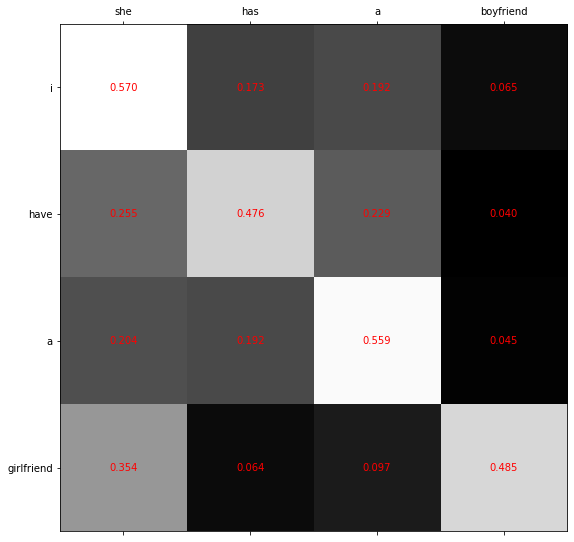

In [63]:
plot_attention_weights("i have a girlfriend", "she has a boyfriend")

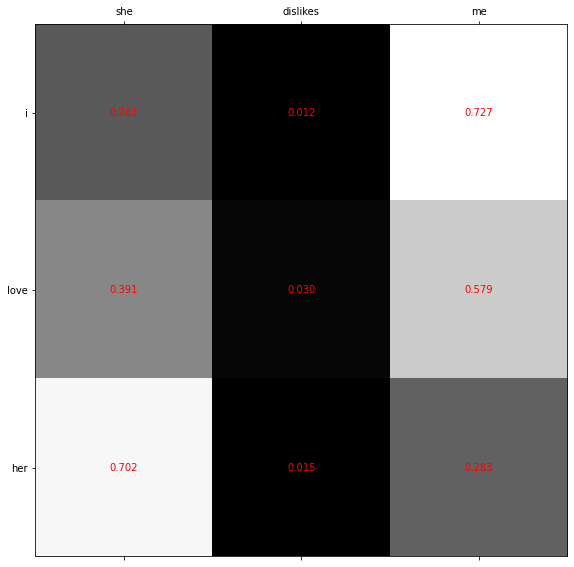

In [64]:
plot_attention_weights("i love her", "she dislikes me")

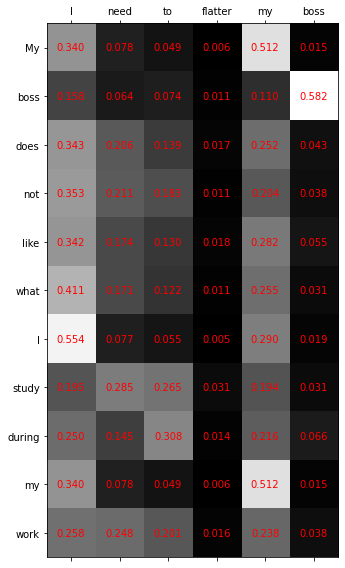

In [65]:
plot_attention_weights("My boss does not like what I study during my work", "I need to flatter my boss")